In [16]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from mcp_persor import BVHparser

from sklearn import svm
import matplotlib.pyplot as plt
import japanize_matplotlib


In [17]:
folder = "./logs/refrigerator2"

In [18]:
# グラフを描画する
def plot(
    arr1,
    arr2,
    title,
    xlabel,
    ylabel,
    figsize=(10, 3),
    xlim=(0, 0),
    ylim=(0, 0),
    labels=None
):
    fig = plt.figure(figsize=figsize)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    if xlim[0] < xlim[1]:
        plt.xlim(xlim[0], xlim[1])

    if ylim[0] < ylim[1]:
        plt.ylim(ylim[0], ylim[1])

    if labels:
        colors = ['mediumblue', 'orange', 'green', 'red', 'purple', 'gray', 'olive', 'cyan']
        for i, label in enumerate(labels):
            color = colors[i % len(colors)]
            for s, e in label['times']:
                plt.axvspan(s, e, color=color, alpha=0.2)

    plt.plot(arr1, arr2, label='arr1')
    plt.show()


13 13


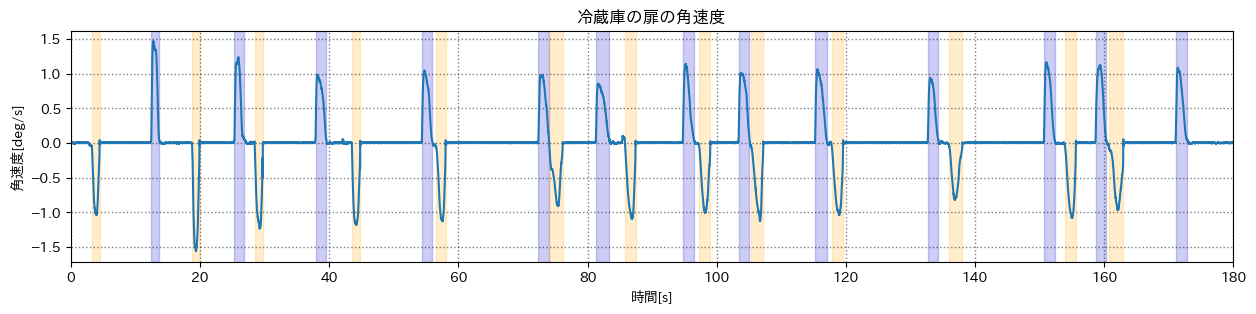

In [19]:
# ラベルを生成
def extract_times(df):
    times = [
        [],
        []
    ]
    current_state = 0
    start_time = df.iloc[0]["time"]

    for index, row in df.iterrows():
        if current_state != row["state"]:
            if current_state != 0:
                times[int(current_state - 1)].append((start_time, row["time"]))
            start_time = row["time"]
            current_state = row["state"]

    return times

df_gyro = pd.read_csv(
    f"{folder}/Gyroscope.csv",
    header=0,
    names=("time", "x", "y", "z")
)

# 閾値を設定
threshold_open = 0.05
threshold_close = -0.05

# 閾値を超えたら開閉を判定(開ける:1 閉める:2 その他:0)
df_gyro["state"] = 0
df_gyro.loc[df_gyro["z"] > threshold_open, "state"] = 1
df_gyro.loc[df_gyro["z"] < threshold_close, "state"] = 2

# ラベルを付ける
times = extract_times(df_gyro)

# times の間隔が短いものを削除
times = [
    [time for time in times[0] if time[1] - time[0] > 0.5],
    [time for time in times[1] if time[1] - time[0] > 0.5]
]

print(len(times[0]), len(times[1]))

labels = [
    {
        "num": 1,
        "name": "開ける",
        "times": times[0]
    },
    {
        "num": 2,
        "name": "閉める",
        "times": times[1]
    }
]

plot(
    df_gyro["time"],
    df_gyro["z"],
    title="冷蔵庫の扉の角速度",
    xlabel="時間[s]",
    ylabel="角速度[deg/s]",
    figsize=(15, 3),
    xlim = xlim,
    labels=labels
)


In [20]:
# 窓ごとの特徴量を抽出
## データの読み込み
bvhp = BVHparser(f'{folder}/main.bvh')
df = bvhp.get_motion_df()

# 窓ごとの特徴量を抽出する関数
def calculate_features(window):
    features = []
    
    # 中央値の計算
    median_time = window['time'].mean()
    
    # 平均、分散、相関、ゼロ交差数、エネルギー、エントロピーの計算
    for joint in columns:
        X_rotate = window[joint + '_Xrotation'].values
        Y_rotate = window[joint + '_Yrotation'].values
        Z_rotate = window[joint + '_Zrotation'].values
        
        # 平均
        mean_value = np.mean([X_rotate, Y_rotate, Z_rotate])
        # 分散
        variance_value = np.var([X_rotate, Y_rotate, Z_rotate])
        # 相関
        correlation_value = np.corrcoef([X_rotate, Y_rotate, Z_rotate])[0, 1]
        # ゼロ交差数
        zero_crossings = np.sum(np.diff(np.signbit([X_rotate, Y_rotate, Z_rotate])) != 0)
        # エネルギー
        energy_value = np.sum(np.square([X_rotate, Y_rotate, Z_rotate]))
        # エントロピー
        # entropy_value = entropy([X_rotate, Y_rotate, Z_rotate])
        
        # features.extend([mean_value, variance_value, correlation_value, zero_crossings, energy_value, entropy_value])
        features.extend([mean_value, variance_value, correlation_value, zero_crossings, energy_value])
    
    return [median_time] + features

# 窓ごとの特徴量を計算し、結果をデータフレームに格納
window_size = 30
window_stride = 1

columns = [j for j in bvhp.get_joints() if not j.startswith('_')]
windows = [df.iloc[i:i + window_size] for i in range(0, len(df), window_stride) if i + window_size <= len(df)]
# result_columns = ['time'] + [f'{joint}_{metric}' for joint in columns for metric in ['mean', 'var', 'corr', 'zero_cross', 'energy', 'entropy']]
result_columns = ['time'] + [f'{joint}_{metric}' for joint in columns for metric in ['mean', 'var', 'corr', 'zero_cross', 'energy']]
result_data = [calculate_features(window) for window in windows]
result_df = pd.DataFrame(result_data, columns=result_columns)


In [21]:
# ラベル情報をもとにstateカラムを追加
result_df['state'] = 0  # 初期値として全ての行に0を設定

for label in labels:
    for time_range in label['times']:
        start_time, end_time = time_range
        result_df.loc[(result_df['time'] >= start_time) & (result_df['time'] <= end_time), 'state'] = label['num']

# 結果をCSVファイルに書き出し
# result_df.to_csv('./logs/refrigerator.csv', index=False)


In [22]:
# svmの学習

# data の 'state' 'time' 以外, NaN を 0 で埋める
data = result_df.drop(['state', 'time'], axis=1).fillna(0)
# target は 'state'
target = result_df['state']

# 学習
clf = svm.SVC(gamma="scale")
clf.fit(data, target)

# 予測
test_data = result_df.drop(['time', 'state'], axis=1).fillna(0)
ans = clf.predict(test_data)

# ans の window_size ごとの最頻値を取得
window_size = 60
ans_series = pd.Series(ans)
ans_smooth = ans_series.rolling(window_size).apply(lambda x: x.mode().iloc[0])


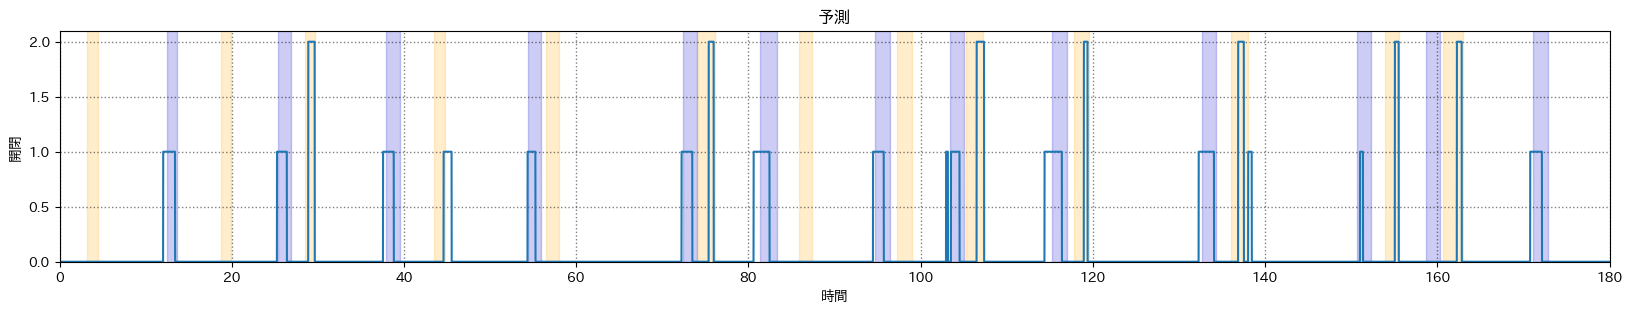

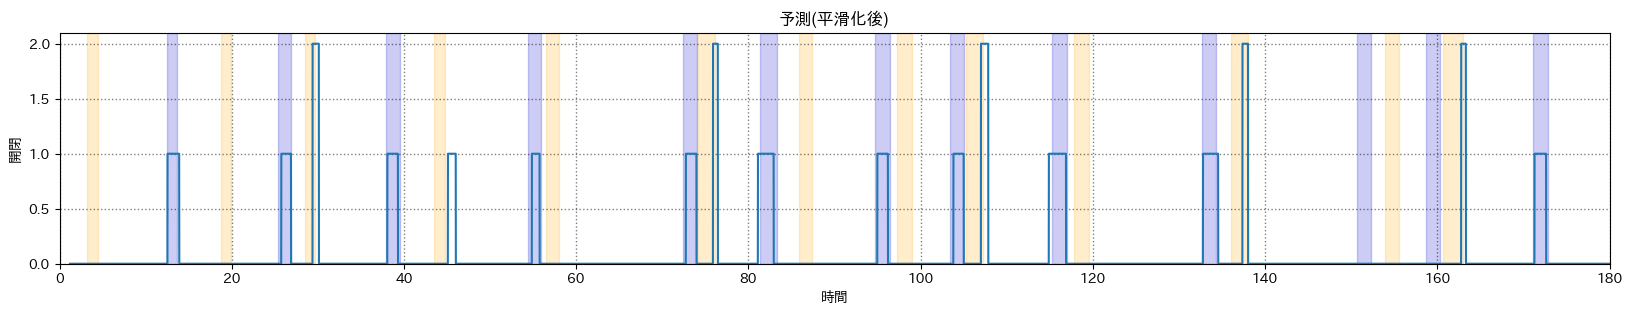

In [23]:
# 結果をグラフ化
xlim = (0, 180)
figsize=(20, 3)

# 予測
plot(
    result_df['time'],
    ans,
    '予測',
    '時間',
    '開閉',
    xlim=xlim,
    ylim=(0, 2.1),
    labels=labels,
    figsize=figsize
)

plot(
    result_df['time'],
    ans_smooth,
    '予測(平滑化後)',
    '時間',
    '開閉',
    xlim=xlim,
    ylim=(0, 2.1),
    labels=labels,
    figsize=figsize
)